In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from diffractio import np, sp, plt, nm, um, mm, degrees
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_sources_XY import Scalar_source_XY

number of processors: 8
total memory        : 15.5 Gb
available memory    : 52 %
max frequency       : 3100 GHz


In [3]:
from py_pol.jones_matrix import Jones_matrix
from py_pol.jones_vector import Jones_vector

In [4]:
from py_aocg.SLM_system import cargar_Jones_SLM, SLM_system_field
from py_aocg.ifta.algorithms import distances_scalar

py_aocg
number of processors: 8
total memory        : 15.5 Gb
available memory    : 51 %
max frequency       : 3100 GHz


## Cargar Matrices de polarización de Holoeye

In [5]:
S_incident=Jones_vector('incident')
S_incident.linear_light(azimuth=45*degrees)

incident = 
[+0.707+0.000j ]   
[+0.707+0.000j ]   

In [6]:
Jslm=cargar_Jones_SLM(type="Jones")

## Captura de campos fabricables

In [7]:
##Interesantes
# angles=np.array((0,45*degrees,0,90*degrees))

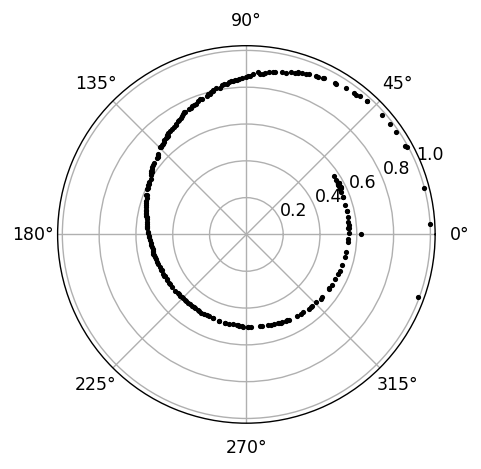

In [8]:
# Hay que normalizar las amplitudes

angles=np.array((0,45*degrees,0,90*degrees))
amplitude, phase, fields=SLM_system_field(angles, Jslm, E0=S_incident)

amplitude = amplitude / amplitude.max()

Es_posible = amplitude*np.exp(1j*phase)

plt.polar(phase, amplitude, 'k.', ms=4)

## Distancias entre campo escalar y fabricable
Estamos en modo escalar. Queremos calcular las distancias entre un campo complejo $A(x,y)e^{i \phi(x,y)}$ y unos elementos fabricables $A_f(x,y)e^{i \phi_f(x,y)}$. Pasamos a campos Er y Ei pues es más sencillo medir distancias

In [9]:
def distances_scalar_backup(DOE, Es_posible):
    """Scalar distancias between a N x M complex field and the manufacturable fields K complex
    
    Arguments:
        DOE (np.array complex): NxM complex array with desired DOE
        ES_posible (np.array complex): K complex array with fabricable fields
        
    Returns:
        DOE_new (np.array complex): NxM complex array with fabricable positions
        i_positions (np.array int): NxM int array with selected positions
        distances (np.array float): NxM minimum distances between DOE and Es_posible
    
    """
    
    DOE_r = np.real(DOE)
    DOE_i = np.imag(DOE)
    Ef_r = np.real(Es_posible)
    Ef_i = np.imag(Es_posible)
    
    x1=np.stack((DOE_r,DOE_i),axis=2)
    x2=np.stack((Ef_r, Ef_i), axis=1)
    distance = (x1[np.newaxis,:,:,:]-x2[:,np.newaxis, np.newaxis, :])**2
    distances=np.sqrt(distance.sum(axis=3))
    distances_min = distances.min(axis=0)
    i_mins=(distances==distances_min)
    i_positions=np.argmax(i_mins, axis=0)
    DOE_new=np.zeros_like(i_positions,dtype=complex)
    for i, E_posible in enumerate(Es_posible):
        DOE_new[i_positions==i]=E_posible

    return DOE_new, i_positions, distances_min

## Target

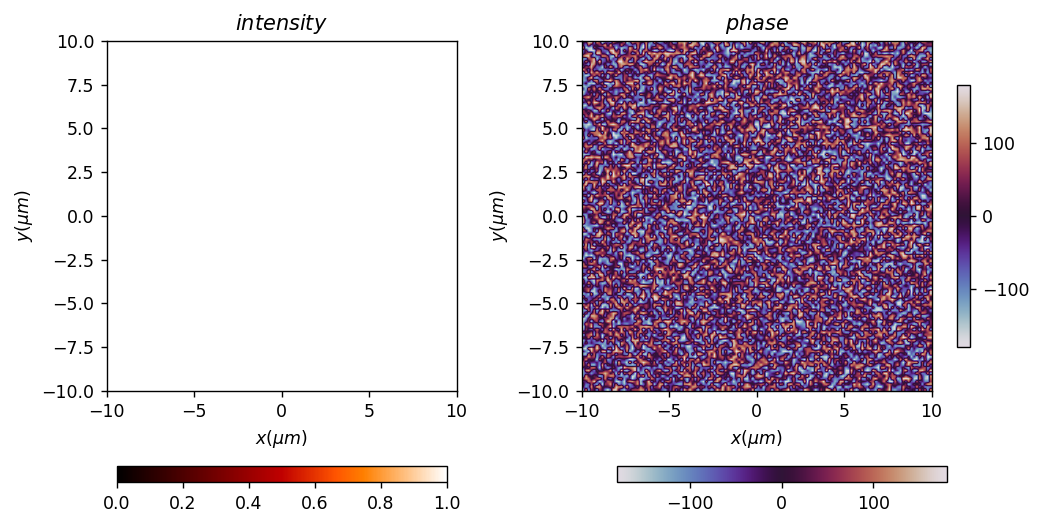

In [10]:
num_x=128
num_y=128
DOE_size=20*um

x=np.linspace(-DOE_size/2,DOE_size/2, num_x)
y=np.linspace(-DOE_size/2,DOE_size/2, num_y)
wavelength=0.6328*um

source=Scalar_source_XY(x,y,wavelength)
source.plane_wave()

target=Scalar_mask_XY(x,y,wavelength)
target.circle(r0=(0,0), radius=(1,1), angle=0)
target.roughness(.1,0.25)
target.draw('field',has_colorbar='vertical');

## Algoritmo

In [11]:
DOEu = target.ifft(matrix=True, remove0=False)
DOEu = DOEu/np.abs(DOEu).max()

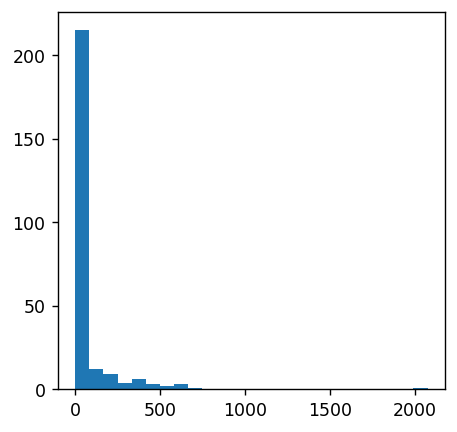

In [12]:
DOE_new, i_positions, distances=distances_scalar(DOEu, Es_posible,
                                                has_draw=True)

Aquí intentamos el algortimo de GS para optimizar la intensidad con el campo vectorial

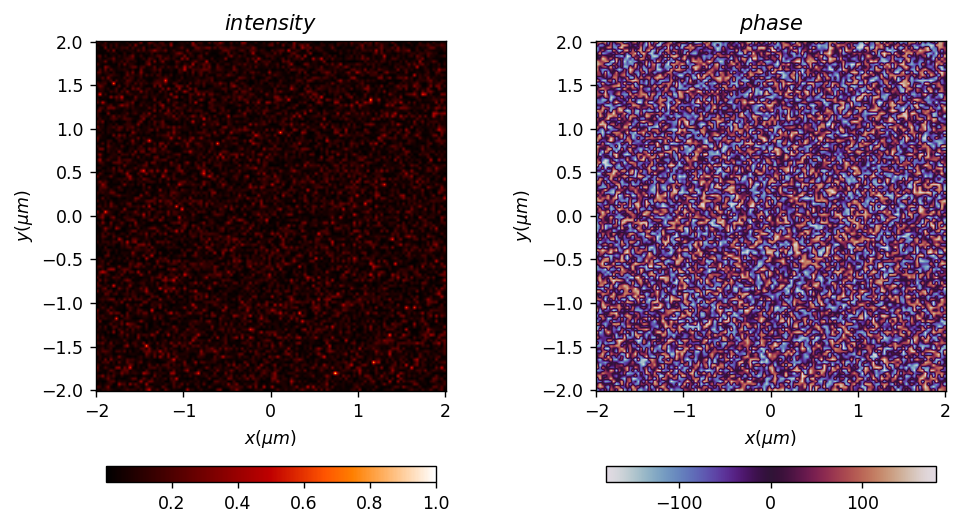

In [13]:
DOE_f= target.ifft(new_field=True, remove0=False)
DOE_f.normalize()
DOE_f.draw('field');

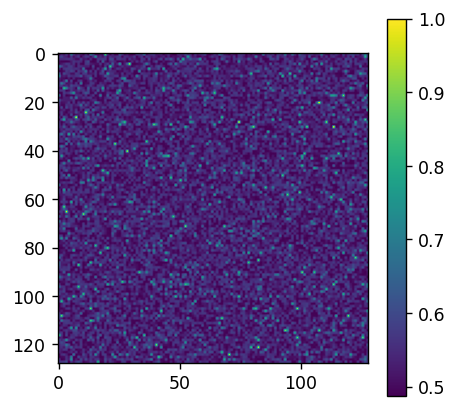

In [14]:
plt.imshow(np.abs(DOE_new))
plt.colorbar()